# Load CSV File into Dataframe

In [22]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,6)})
%matplotlib inline
df = pd.read_csv('./monthly_temperature_aomori_city.csv')
df['DATE'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
df['temperature'] = df['temperature']*(9/5)+32
df.set_index('DATE',inplace=True)
df.to_csv('./monthly_temperature_aomori_city_updt.csv',index=True)
df.head()

,year,month,temperature
DATE,,,
1882-01-01,1882,1,31.28
1882-02-01,1882,2,30.92
1882-03-01,1882,3,34.16
1882-04-01,1882,4,48.02
1882-05-01,1882,5,53.78


## Data Analysis and Visualization

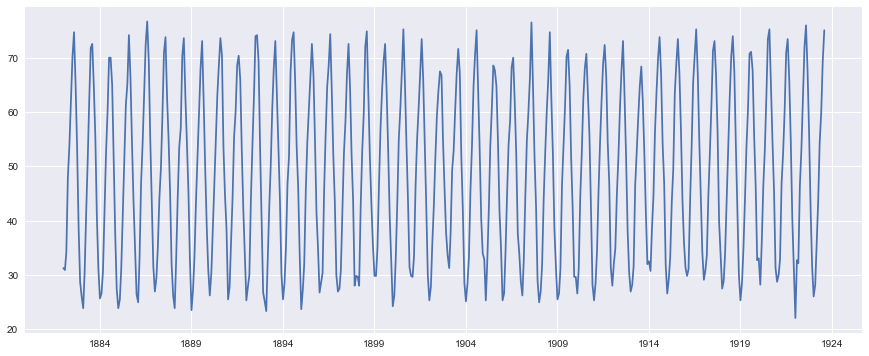

In [23]:
plt.figure(figsize=(15,6))
plt.plot(df[:500].temperature)

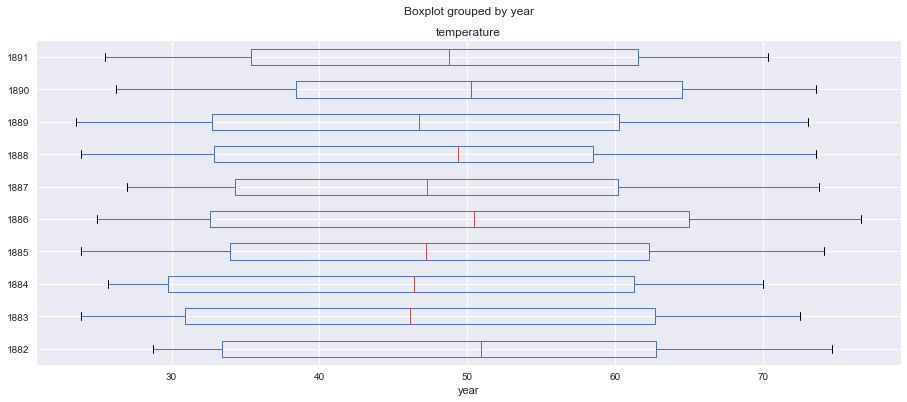

In [24]:
df[:120].boxplot(figsize=(15,6),by='year',column='temperature',vert=False)
df.drop(['year','month'],inplace=True,axis=1)

## Data Decomposition

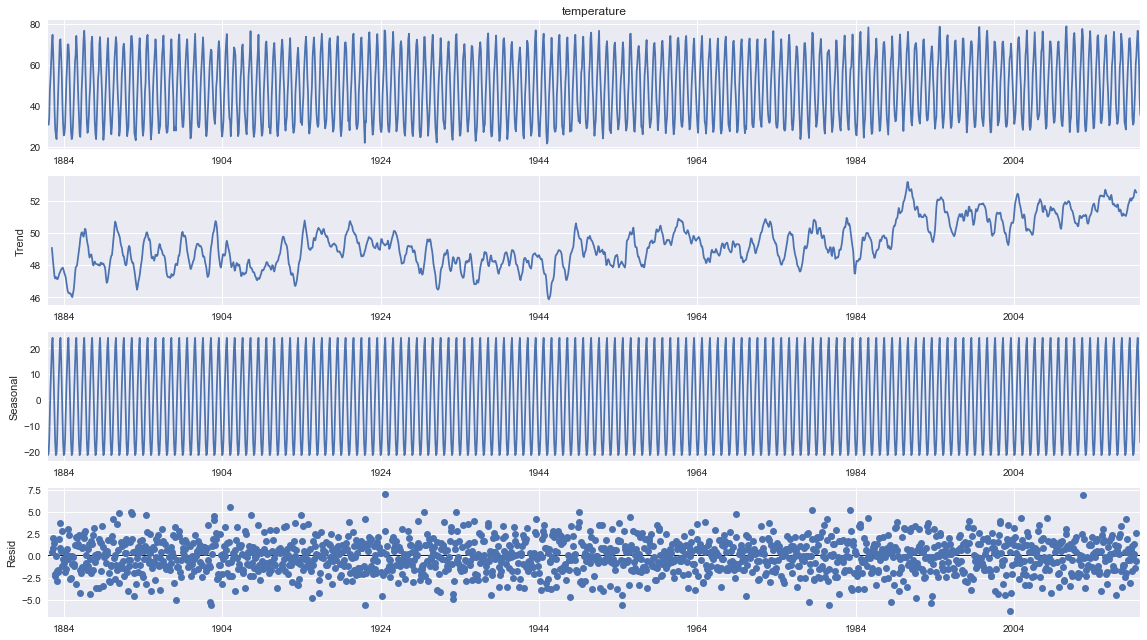

In [25]:
decomposition = sm.tsa.seasonal_decompose(df.temperature, model='additive')
plt.rcParams["figure.figsize"] = [16,9]
fig = decomposition.plot()

## Check Data Stationarity

In [26]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(timeseries):    
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [27]:
check_stationarity(df.temperature)

The test statistic: -2.936397
p-value: 0.041276
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


## Log Transformation

In [28]:
import numpy as np
ts_temp_log = np.log(df)
ts_temp_log

,temperature
DATE,
1882-01-01,3.442979
1882-02-01,3.431403
1882-03-01,3.531055
1882-04-01,3.871618
1882-05-01,3.984902
...,...
2019-08-01,4.339119
2019-09-01,4.250778
2019-10-01,4.080584


## Data Difference - To determine value of d

In [29]:
np.diff(ts_temp_log.temperature)

array([-0.01157569,  0.09965215,  0.34056222, ..., -0.1701947 ,
       -0.31150765, -0.19673036])

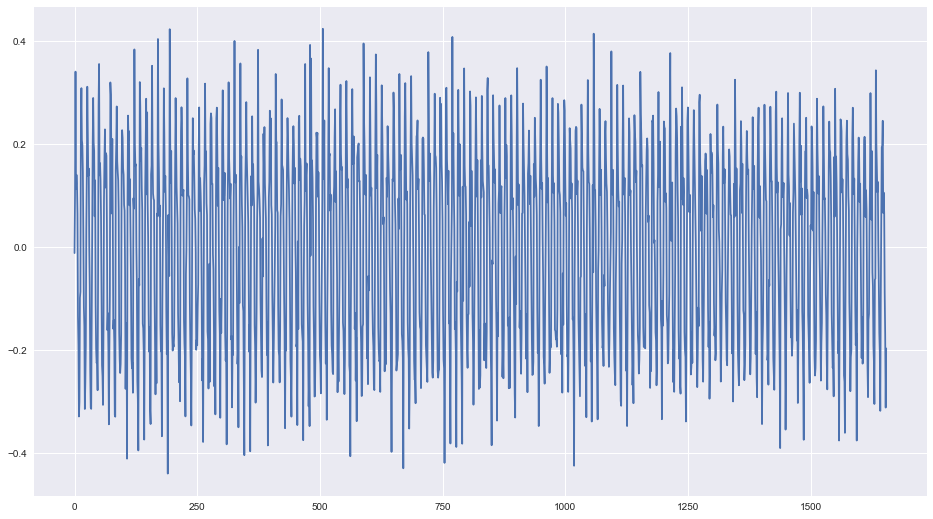

In [30]:
# Plot Data Difference to check stationary
ts_temp_log_diff = np.diff(ts_temp_log.temperature)
plt.plot(ts_temp_log_diff)

In [31]:
# Check Stationarity
check_stationarity(ts_temp_log_diff)

The test statistic: -15.725118
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


## Plot ACF and PACF

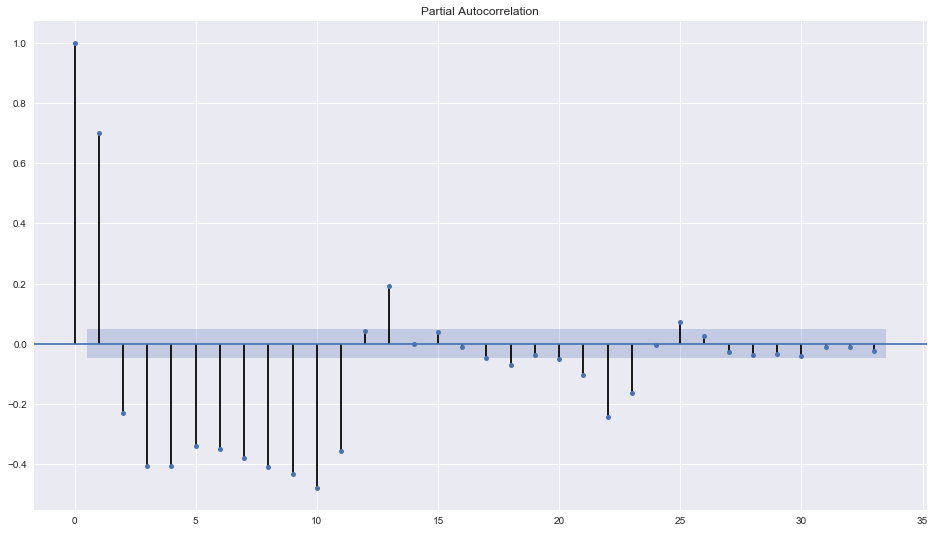

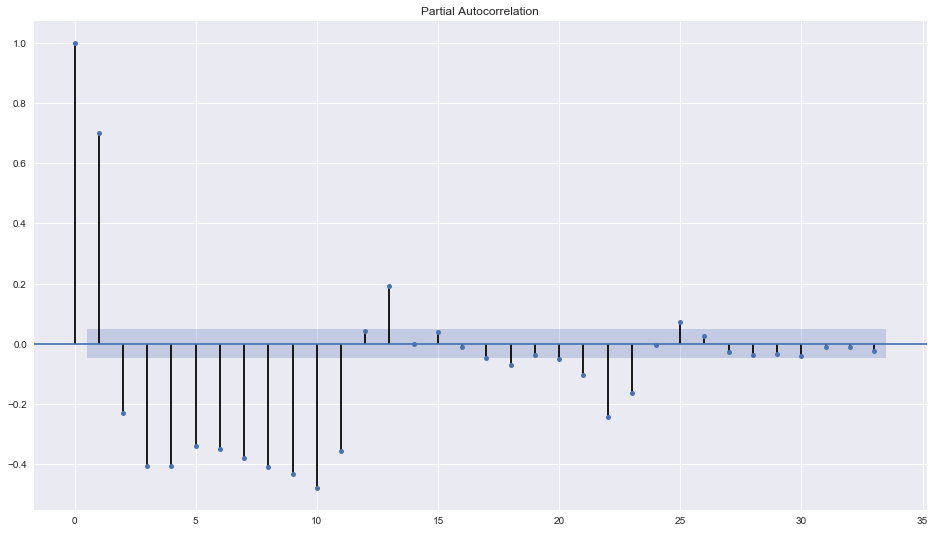

In [32]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(10,2))
plot_pacf(ts_temp_log_diff)

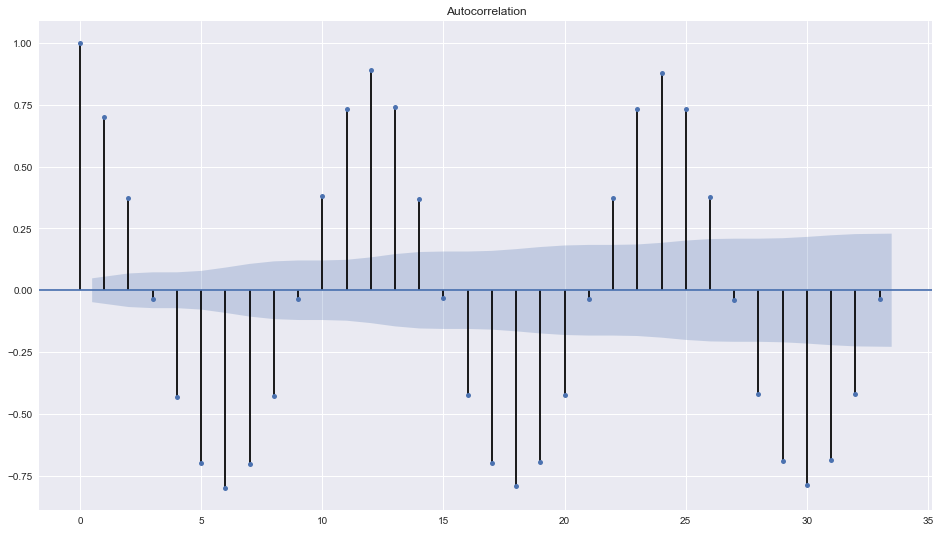

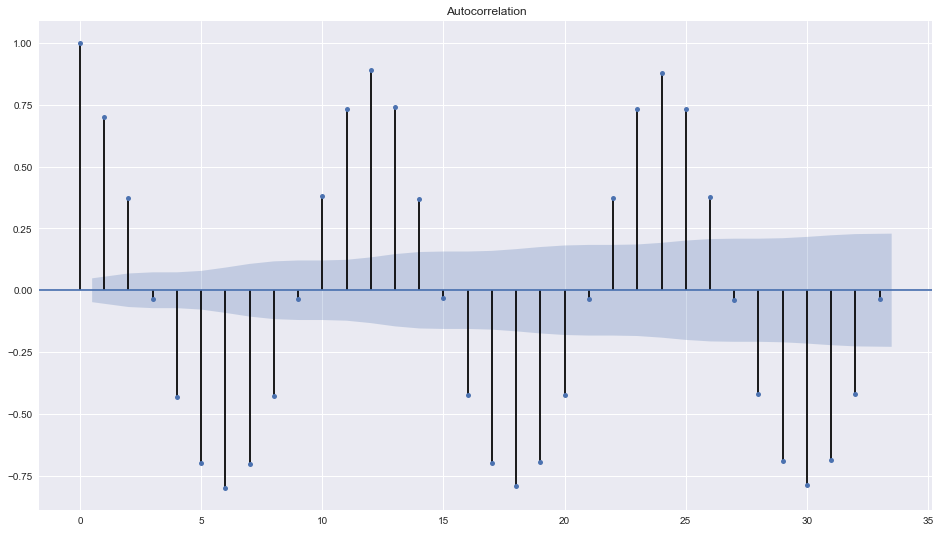

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts_temp_log_diff)

## Fitting an ARMA Model First

In [ ]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(df.temperature, (3, 3)).fit()
model.summary()

## ARMA Residual Plot

In [ ]:
model.resid.plot()

## ARMA Predict vs Expected

In [ ]:
model.plot_predict(1, 30)
plt.show()

## Forecasting using ARMA forecast function

In [ ]:
n=36
forecast,err,ci = model.forecast(steps=n)

In [ ]:
df_forecast = pd.DataFrame({'forecast':forecast},index=pd.date_range(start='1/1/2020', periods=n, freq='MS'))
ax = df[1600:].temperature.plot(label='observed', figsize=(20, 15))
df_forecast.plot(ax=ax,label='Forecast',color='r')
ax.fill_between(df_forecast.index,
                ci[:,0],
                ci[:,1], color='b', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Temp')

plt.legend()
plt.show()

## Fitting ARIMA Model

In [47]:
from statsmodels.tsa.arima_model import ARIMA
mod = ARIMA(df.temperature,order=(6,0,5))
results = mod.fit()
print(results.aic,results.bic)

C:\Users\vbabu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


7616.019291068591 7686.377375422879


C:\Users\vbabu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


## Residual Analysis

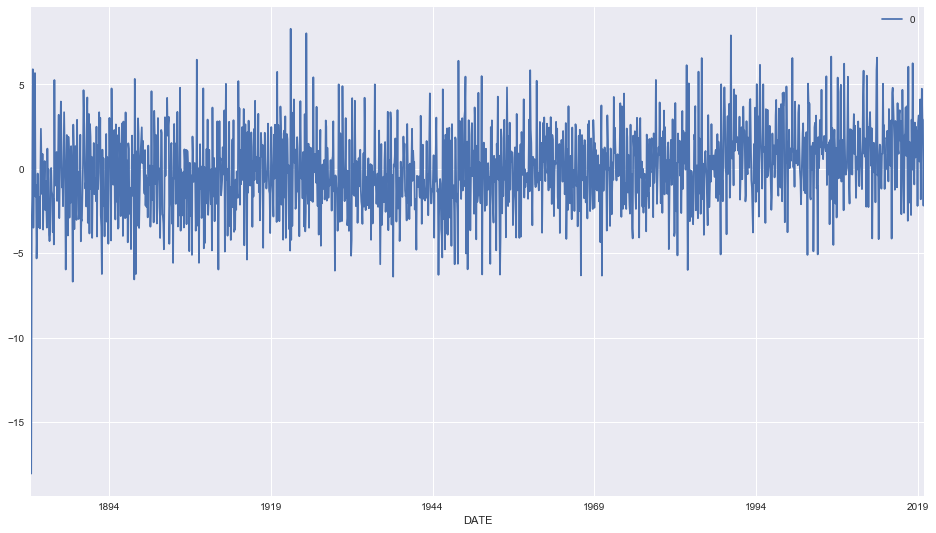

In [48]:
# Residual Plot
residuals = pd.DataFrame(results.resid)
residuals.plot()

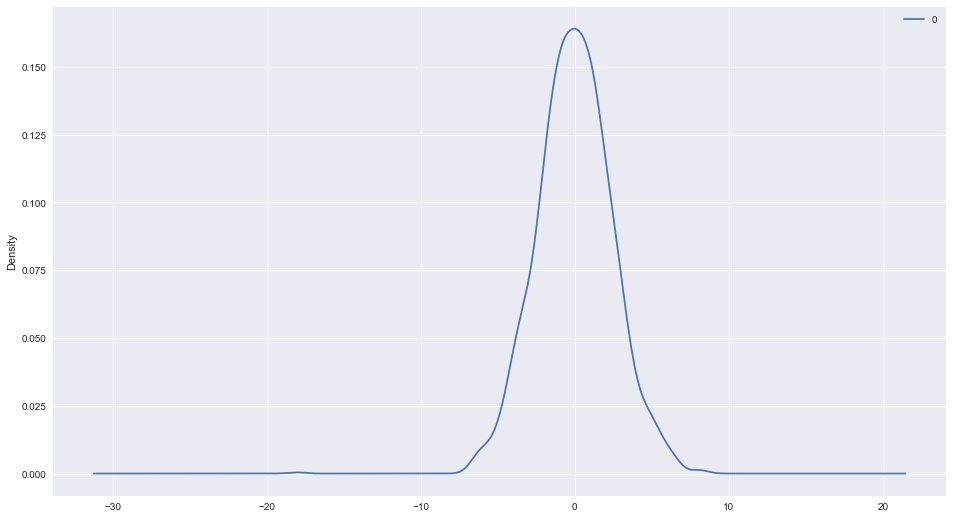

In [49]:
# Residual Density Plot 
residuals.plot(kind='kde')

In [37]:
from statsmodels.stats.diagnostic import acorr_ljungbox
tstat,pval = acorr_ljungbox(residuals)
tstat

C:\Users\vbabu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:496: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)
C:\Users\vbabu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


array([3.31412600e-01, 4.31632375e+00, 7.30677573e+00, 3.33248220e+01,
       5.54402761e+01, 9.32244505e+01, 1.07075146e+02, 1.21807701e+02,
       1.27357367e+02, 1.30743792e+02, 1.45894310e+02, 3.14060757e+02,
       3.44434156e+02, 3.63679981e+02, 3.71519661e+02, 3.81227181e+02,
       3.95259155e+02, 4.21787245e+02, 4.44458539e+02, 4.63312183e+02,
       4.68716864e+02, 4.73279119e+02, 4.91455398e+02, 6.45132322e+02,
       6.67608441e+02, 6.70114147e+02, 6.70874074e+02, 6.95527070e+02,
       7.19881235e+02, 7.56520248e+02, 7.84236796e+02, 7.99995580e+02,
       8.03514438e+02, 8.10779966e+02, 8.25233222e+02, 9.76263855e+02,
       9.86627981e+02, 9.95174982e+02, 9.95677448e+02, 1.01722941e+03])

## ARIMA Predict

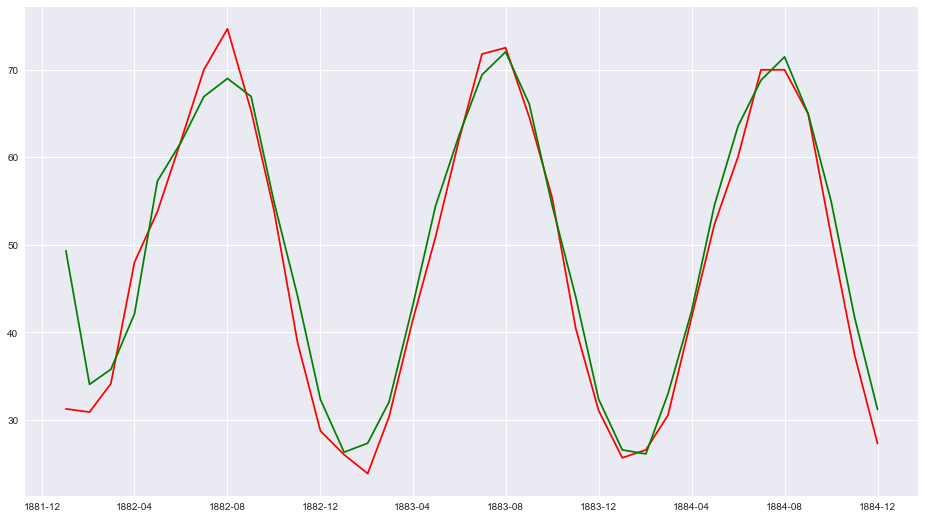

In [50]:
from math import sqrt
from sklearn.metrics import mean_squared_error
plt.plot(df.temperature[:36],color='r')
plt.plot(results.predict()[:36],color='g')

In [51]:
# Root Mean Squared Error
rmse =sqrt(mean_squared_error(df.temperature, results.predict()))
print(rmse)

2.432397381463788


## ARIMA Forecast

In [52]:
# First 3 years i.e. from 2020 to 2023 which is 36 months
# Get forecast value, Stderr and Confidence Interval
n=36
forecast,err,ci = results.forecast(steps=n,alpha=0.05)

In [53]:
df_forecast = pd.DataFrame({'forecast':forecast},index=pd.date_range(start='1/1/2020', periods=n, freq='MS'))

In [57]:
# Checking Forecast Interval returned by forecast function
ci

array([[24.54334751, 33.87712307],
       [22.67086018, 32.99011741],
       [28.71235536, 39.13429983],
       [39.44266615, 49.88850061],
       [50.24095098, 60.69180233],
       [58.81240231, 69.26553384],
       [64.77649348, 75.23022873],
       [65.74146456, 76.19562623],
       [59.62629763, 70.0808021 ],
       [48.79144043, 59.24647509],
       [37.9947166 , 48.4500652 ],
       [29.38735944, 39.84285408],
       [23.43914019, 33.89559893],
       [22.47287976, 32.9301466 ],
       [28.58487127, 39.04246332],
       [39.40937358, 49.86740439],
       [50.21478264, 60.67310676],
       [58.82770412, 69.28618624],
       [64.76742414, 75.22686614],
       [65.7243773 , 76.18461155],
       [59.61893056, 70.0794776 ],
       [48.80065668, 59.26164137],
       [37.98773122, 48.44900152],
       [29.36782801, 39.82925343],
       [23.43525844, 33.89762676],
       [22.48556909, 32.94872488],
       [28.58418097, 39.04764067],
       [39.39522848, 49.85912186],
       [50.21510694,

## Plot Forecast with Confidence Interval

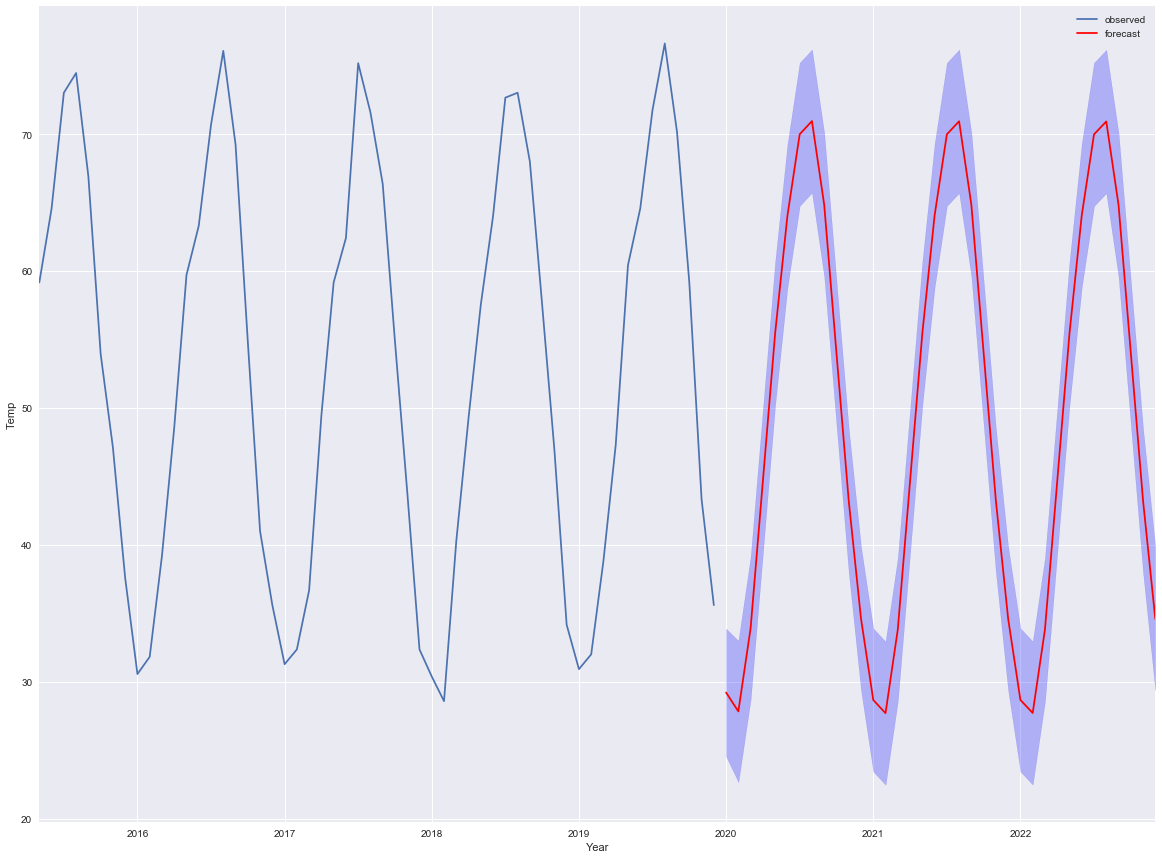

In [56]:
ax = df[1600:].temperature.plot(label='observed', figsize=(20, 15))
df_forecast.plot(ax=ax,label='Forecast',color='r')
ax.fill_between(df_forecast.index,
                ci[:,0],
                ci[:,1], color='b', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Temp')

plt.legend()
plt.show()

### Auto ARIMA

In [ ]:
import pyramid as pm
stepwise_fit = pm.auto_arima(df, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True) 